In [0]:
# Change directory to VSCode workspace root so that relative path loads work correctly. Turn this addition off with the DataScience.changeDirOnImportExport setting
# ms-python.python added
import os
try:
	os.chdir(os.path.join(os.getcwd(), '..'))
	print(os.getcwd())
except:
	pass


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math as math
import pandas as pd
from scipy.integrate import simps
from scipy.integrate import odeint



'__Definición de funciones__'

def find_nearest(array, value):
    '''
    Recibe un array y un valor; devuelve el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return array[idx-1]
    else:
        return array[idx]

def find_nearest_pos(array, value):
    '''
    Recibe un array y un valor; devuelve el índice del elemento con el valor más cercano al recibido
    '''
    idx = np.searchsorted(array, value, side="left")
    if idx > 0 and (idx == len(array) or math.fabs(value - array[idx-1]) < math.fabs(value - array[idx])):
        return idx-1
    else:
        return idx

def eqX(y):
    '''
    Devuelve concentración de equilibrio en fase sólida a partir de una concentración en fase líquida
    '''
    KeqX = [15.80011045, 32.02907632, 5.735438305, 0.053726466, 1.972131456]
    eqX = KeqX[0]*KeqX[1]*y/(1+KeqX[1]*y)+KeqX[2] * KeqX[3]*(y-KeqX[4])/(1-KeqX[3]*(y-KeqX[4]))
    return eqX

def m(y):
    '''
    Devuelve el valor del coeficiente de distribución para una determinada concentración en fase líquida
    '''
    m = y/eqX(y)
    return m

def Bi(y):
    '''
    Calcula el número de Biot en función de una concentración
    '''
    Bi = m(y)*kL*a/Deff
    return Bi    

def batch(X, t):
    '''
    '''
    x = X[0]
    y = X[1]
    dxdt = K * (eqX(y)-x) / (1-eps)
    dydt = -K * (eqX(y) - x) / eps
    return [dxdt, dydt]

def column(F, t):
    '''
    '''
    x = F[::2]
    y = F[1::2]
    y[0] = 0

    dFdt = np.empty_like(F)

    dxdt = dFdt[::2]
    dydt = dFdt[1::2]
    
    '_________________________________________________________________________________________________________________________'

     # A lo largo de todo el extractor la variación de concentración en el sólido en función del tiempo es igual a la
     # ecuación de transferencia de masa

    dxdt[:] = K * (eqX(y[:]) - x[:]) / (1-eps)

    '_________________________________________________________________________________________________________________________'

     # En z = 0 ingresa el solvente, por lo que se considera que no hay acumulación en ese punto

    dydt[0] = 0
    
     # A lo largo del extractor la variación se puede considerar la ecuación general
    difusion = eps * Dax * np.diff(y[:], 2)/dz**2
    conveccion = uz * np.diff(y[:-1], 1)/dz
    transferencia = K * (eqX(y[1:-1]) - x[1:-1])

    dydt[1:-1] = (difusion - conveccion - transferencia)/eps

    dydt[-1] = (eps*Dax*(2*y[-2]-2*y[-1]) - uz *
                (y[-1]-y[-2])/dz - K*(eqX(y[-1]) - x[-1]))/eps

    '_________________________________________________________________________________________________________________________'

    return dFdt

def countercurrent(F, t):
    '''
    '''
    x = F[::2]
    y = F[1::2]

    x[-1] = porcentajeAC*dens
    y[0]= 0.01

    dFdt = np.empty_like(F)

    dxdt = dFdt[::2]
    dydt = dFdt[1::2]

    '_________________________________________________________________________________________________________________________'

    # En el punto de ingreso de sólidos (z = L) no hay variación en función del tiempo
    dxdt[-1] = 0
    
    # A lo largo del extractor se considera la ecuación general
    conveccionS = S/A * np.diff(x[1:], 1)/dz
    transferenciaS = K * (eqX(y[1:-1]) - x[1:-1])
    dxdt[1:-1] = (conveccionS + transferenciaS) / (1-eps)

    dxdt[0] = + (S/A *(x[1]-x[0])/dz +  K * (eqX(y[0])-x[0])) / (1-eps)

    '_________________________________________________________________________________________________________________________'

    # A lo largo del extractor se considera la ecuación general
    dydt[-1] =  ( -uz * (y[-1]-y[-2])/dz - K * (eqX(y[-1])-x[-1])) / (eps)
    
    difusionL = eps * Dax * np.diff(y[:], 2)/dz**2
    conveccionL = uz * np.diff(y[:-1], 1)/dz
    transferenciaL = K * (eqX(y[1:-1]) - x[1:-1])

    dydt[1:-1] = (difusionL - conveccionL - transferenciaL)/eps

    # En el punto de ingreso de solvente (z = 0) se considera que no hay acumulación
    dydt[0] = 0

    '_________________________________________________________________________________________________________________________'

    return dFdt

def error_porcentual(modelo):

    error_porcentual = 0

    for i, dato in enumerate(concentracion_experimental):

        tiempo = tiempo_experimental[i]
        posicion_t = find_nearest_pos(t/60,tiempo)
        
        error = abs((modelo[posicion_t, 1]-dato)/dato)
        error_porcentual += error

    return error_porcentual/(i+1)*100


'__Fuente de gráficos__'
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = '9'


'__Datos Cinéticos Experimentales'
tiempo_experimental = [1,5,10,15,30,46,80,108,142,168,192,1263,1608]                             # min
concentracion_experimental = [0.11,0.21,0.3,0.46,0.72,0.93,1.3,1.37,1.59,1.62,1.58,1.64,1.76]    # g/L
datos_experimentales = [[tiempo_experimental],[concentracion_experimental]]


kb = 1.38*10**-23 # Constante de Boltzmann
e = math.e
pi = math.pi

# Estimación viscosidades
T = 25 + 273

# Definición de propiedades
porcentajeAC = 0.06             # Porcentaje de Ácido Carnósico
dens = 557.82                   # Densidad del sólido
densb = 180                     # Densidad del lecho
densL = 935.69                  # Densidad de fase líquida
Deff = (1.3*(10**-10))/60       # Difusividad efectiva en sólido
phi = 2.012453362               # Factor de forma
a = 0.000706498099              # Longitud característica
ap = 3362                       # Área equivalente
Deq = 6/ap                      # Diámetro equivalente a esfera
eps = 1.-densb/dens             # Porosidad del lecho

# Propiedades estimadas
viscH2O = e**(-52.843 + 3703.6/T + 5.866*math.log(T) - 5.98*10**(-29)*(T)**10)
viscEtOH = e**(7.875+781.98/T -3.0418*math.log(T)) 
visc = 0.01
rad = math.pow(326.5*(3/(4*pi)), 1/3)*10**(-10)                     # radio molecular de van der waals
Dab = kb*T/(6*pi*visc*rad)                                          # Ecuación de Einstein para difusividad

# Definición de parámetros de diseño
L = 4.421                                                           # Longitud del equipo
Dc = 0.2                                                            # Diámetro del equipo
A = math.pi*(Dc/2)**2                                               # Área del equipo

# Definición de parámetros de proceso
W = 1000/(3600*7*5*4)                                               # Materia prima a tratar, por hora (7 horas, 5 días, 4  semanas)
S = 1.072*10**-6                                                    # Flujo volumétrico de sólidos (m³/s)
nu = 2.249*10**-6                                                   # Flujo volumétrico de solvente (m³/s)
tau = 7*3600                                                        # Tiempo máximo a calcular en la simulación



# Estimación de números adimensionales y coeficientes
uz = nu/(A)                                                         # Velocidad lineal de solvente
Re = uz*Deq*densL/(visc*(1-eps))                                    # Número de Reynolds
Pe = 0.2/eps + 0.011/eps + math.pow(eps*Re, 0.48)                   # Número de Peclet
Sc = visc/(densL*Dab)                                               # Numero de Schmidt   
ShL = (0.765/(Re**0.82) + 0.365/(Re**0.386))*Re*(Sc**(1/3))/eps     # Número de Sherwood
Dax = Deq*uz/(eps*Pe)                                               # Dispersión axial
kL = ShL*Dab/a                                                      # Transferencia de masa en fase líquida

# Definición de la constante global de transferencia de masa
K = 8.07*10**-9
K = K*ap


# Cálculo de tiempos de residencia para el líquido y el sólido
resTime = A*L*eps/nu
resTimeS = A*L*(1-eps)/S


In [2]:
# Print de datos
print(f'''Propiedades:
Porcentaje de ácido carnósico:  {porcentajeAC*100} %
Densidad del sólido:            {dens}  Kg/m³
Densidad del lecho:             {densb} Kg/m³
Densidad de fase líquida:       {densL} Kg/m³
Difusividad efectiva:           {Deff}  m²/s
Factor de forma:                {phi}
Longitud característica:        {a}     m
Área específica:                {ap}    1/m
Diámetro equivalente:           {Deq}   m
Porosidad del lecho:            {eps}
''')

print(f'''Propiedades Estimadas:
Viscosidad: {visc} Pa.s
Radio van der waals: {rad} m
''')

print(f'''Parámetros de diseño:
Largo total de equipo:      {L}     m
Diámetro de contacto:       {Dc}    m
''')

print(f'''Parámetros de proceso:
Flujo materia prima:{S*dens*3600} Kg/h
Flujo de solvente: {nu*3600}m³/h
''')

print(f'''Parámetros:
Velocidad lineal:   {uz}    m/s
Reynolds:           {Re}
Peclet:             {Pe}
Schmidt:            {Sc}
SherwoodL:          {ShL}    
Dax:                {Dax}   m²/s
Dab:                {Dab}   m²/s
kL:                 {kL}    m/s
Bi:                 {Bi(15)}''')

print('\n\n')
print(f'Masa de sólido por hora: {round(S*3600*dens,2)} Kg/h')
print(f'Volumen de solvente por hora: {round(nu*3600*1000,2)} L/h')
print(f'Tiempo de residencia de líquido:  {round(resTime/3600,2)}')
print(f'Tiempo de residencia de sólido: {round(resTimeS/3600,2)}')
print('\n\n')





Propiedades:
Porcentaje de ácido carnósico:  6.0 %
Densidad del sólido:            557.82  Kg/m³
Densidad del lecho:             180 Kg/m³
Densidad de fase líquida:       935.69 Kg/m³
Difusividad efectiva:           2.166666666666667e-12  m²/s
Factor de forma:                2.012453362
Longitud característica:        0.000706498099     m
Área específica:                3362    1/m
Diámetro equivalente:           0.001784651992861392   m
Porosidad del lecho:            0.6773152629880608

Propiedades Estimadas:
Viscosidad: 0.01 Pa.s
Radio van der waals: 4.2716748924401603e-10 m

Parámetros de diseño:
Largo total de equipo:      4.421     m
Diámetro de contacto:       0.2    m

Parámetros de proceso:
Flujo materia prima:2.1527389440000007 Kg/h
Flujo de solvente: 0.0080964m³/h

Parámetros:
Velocidad lineal:   7.158789340273451e-05    m/s
Reynolds:           0.03704645772561032
Peclet:             0.48204511933451466
Schmidt:            209253.13663163266
SherwoodL:          41.2805147218

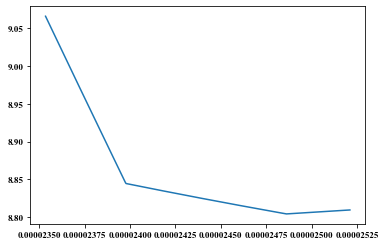

Mínimo error porcentual: 8.804404231646746 con Ka = 2.486199e-05


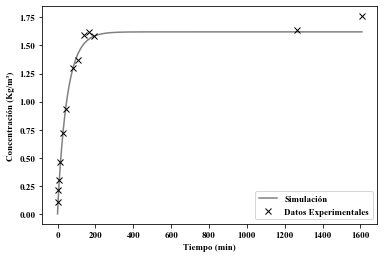

In [3]:
'__Ajuste de K y comparación de datos experimentales con modelo__'
eps = 0.9177
t = np.linspace(0,tiempo_experimental[-1]*60,100000)

x0=porcentajeAC*dens
y0=0

mat_Ka = np.array([])
mat_error = np.array([])
sol = odeint(batch,[x0,y0],t)

for K in range(7000,7500):
    K = K*10**-12*ap
    sol = odeint(batch,[x0,y0],t)
    error = error_porcentual(sol)
    mat_Ka = np.append(mat_Ka, K)
    mat_error = np.append(mat_error, error)
plt.plot(mat_Ka,mat_error)
plt.show()

# Defino K como el que dio el mínimo error cuadrado
K = float(mat_Ka[np.where(mat_error == mat_error.min())])
print(f'Mínimo error porcentual: {mat_error.min()} con Ka = {K}')

# Grafico
plt.plot(t/60, sol[:,1], label="Simulación",color='grey')
plt.plot(tiempo_experimental, concentracion_experimental,
marker='x',linestyle=' ', label='Datos Experimentales', color='black')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()



    Rendimiento a eps:0.6773152629880608 -> 0.4202547285996273
    Concentración final: 6.701090787254242
    Volumen: 0.27777777777777785
    

    Rendimiento a eps:0.7374114472410456 -> 0.45625131577952815
    Concentración final: 5.437701658060399
    Volumen: 0.34135017779036275
    

    Rendimiento a eps:0.7975076314940304 -> 0.4904455654122283
    Concentración final: 4.167829616301655
    Volumen: 0.44265692495636266
    

    Rendimiento a eps:0.8576038157470152 -> 0.5191509133651232
    Concentración final: 2.8850317787179263
    Volumen: 0.6294736733305707
    

    Rendimiento a eps:0.9177 -> 0.5398333182578179
    Concentración final: 1.6203324169273876
    Volumen: 1.089120889064193
    


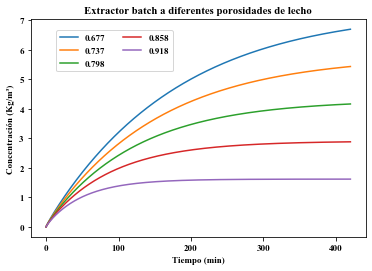

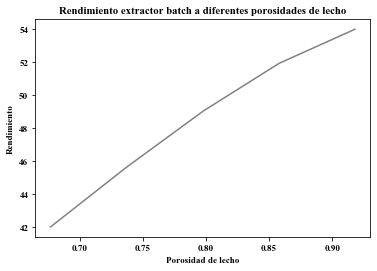

In [4]:
'__Calculo de batchs variando densidad de lecho__'

soluciones = []
rendimientos = []
epsilons = np.linspace(1-densb/dens, 0.9177, 5)
for eps in epsilons:

    nt = 10000
    t = np.linspace(0,tau, nt)
    x0 = porcentajeAC*dens
    y0 = 0
    
    sol = odeint(batch, [x0,y0], t)
    
    rendimiento = 1-sol[-1][0]/sol[0][0]
    rendimientos.append(round(rendimiento*100,2))

    print(f'''
    Rendimiento a eps:{eps} -> {1-sol[-1][0]/sol[0][0]}
    Concentración final: {sol[-1][-1]}
    Volumen: {W*t[-1]/((1-eps)*dens)}
    ''')
    soluciones.append([eps,sol])

for sol in soluciones:
    plt.plot(t/60, sol[1][:,1],label=f"{round(sol[0],3)}")

plt.title("Extractor batch a diferentes porosidades de lecho")
plt.legend(loc='upper center', bbox_to_anchor=(0.25, +0.97), shadow=False, ncol=2)
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.show()

# rendimientos = []
# for sol in soluciones:


plt.plot(np.round(epsilons,3),rendimientos, color='grey')
plt.xlabel('Porosidad de lecho')
plt.ylabel('Rendimiento')
plt.title("Rendimiento extractor batch a diferentes porosidades de lecho")
plt.show()

eps = 0.737


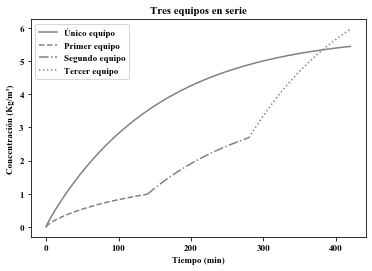


Concentración final con un equipo: 5.446354449672233
Concentración final con tres equipos: 5.96268784365396
Rendimiento con tres equipos: 49.923906061622944
Rendimiento 1er equipo: 14.163076562808497
Rendimiento 2do equipo: 19.643971174117947
Rendimiento 3er equipo: 41.66135297851245
Volumen con un equipo: 0.3408161565398598
Volumen individual tres equipos: 0.11357130048913021
Mejora Porcentual con tres equipos: 9.480348713124982



In [5]:
'__Calculo de tres batchs en serie__'

tau = 7*3600
t = np.linspace(0,tau, nt)

t1 = t[:int(nt/3)]
t2 = t[int(nt/3):int(nt*2/3)]
t3 = t[int(nt*2/3):]

sol0 = odeint(batch,[x0,y0],t)
sol1 = odeint(batch, [sol0[-1][0],y0], t1)
sol2 = odeint(batch, [sol1[-1][0],y0], t2)
sol3 = odeint(batch, [sol2[-1][0],y0], t3)

lista = []

for i in range(0,10):
    sol1 = odeint(batch, [sol2[-1][0], y0], t1)
    sol2 = odeint(batch, [sol3[-1][0], sol1[-1][1]], t2)
    sol3 = odeint(batch, [x0, sol2[-1][1]], t3)
    lista.append(sol3[-1][1])

plt.plot(t/60, sol0[:, -1], ls='solid', color='grey', label='Único equipo')
plt.plot(t1/60, sol1[:, -1], ls='dashed', color='grey', label='Primer equipo')
plt.plot(t2/60, sol2[:, -1], ls='dashdot', color='grey', label="Segundo equipo")
plt.plot(t3/60, sol3[:, -1], ls='dotted', color='grey', label="Tercer equipo")

conc_final_3 = sol3[-1,-1]
rendimiento_3 = 100*(1 - sol1[-1][0]/sol3[0][0])

rendimiento_3_1 = 100*(1- sol1[-1][0]/sol1[0][0])
rendimiento_3_2 = 100*(1- sol2[-1][0]/sol2[0][0])
rendimiento_3_3 = 100*(1- sol2[-1][0]/sol3[0][0])

V_1 = W*t[-1]/((1-eps)*dens)
V_3 = W*t1[-1]/((1-eps)*dens)

plt.title('Tres equipos en serie')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()

print(f'''
Concentración final con un equipo: {sol0[-1][1]}
Concentración final con tres equipos: {conc_final_3}
Rendimiento con tres equipos: {rendimiento_3}
Rendimiento 1er equipo: {rendimiento_3_1}
Rendimiento 2do equipo: {rendimiento_3_2}
Rendimiento 3er equipo: {rendimiento_3_3}
Volumen con un equipo: {V_1}
Volumen individual tres equipos: {V_3}
Mejora Porcentual con tres equipos: {100*(sol3[-1][1]-sol0[-1][1])/sol0[-1][1]}
''')




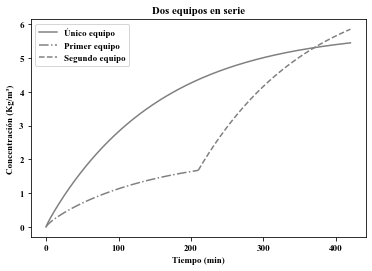


Concentración final con dos equipos: 5.849460739813644
Rendimiento con dos equipos: 48.97587886438002
Rendimiento 1er equipo: 21.55232139694434
Rendimiento 2do equipo: 34.95776797436086
Volumen con un equipo: 0.3408161565398598
Volumen individual dos equipos: 0.1703910357578517
Mejora Porcentual con dos equipos: 7.40139654637553



In [6]:
'__Calculo de dos batchs en serie__'

convergencia = []

t1 = t[:int(nt/2)]
t2 = t[int(nt/2):]

for i in range(0,10):
    sol1 = odeint(batch, [sol2[-1][0], y0], t1)
    sol2 = odeint(batch, [x0, sol1[-1][-1]], t2)
    convergencia.append(sol1[-1][1])

conc_final_2 = sol2[-1][-1]
rendimiento_2 = 100*(1 - sol1[-1][0]/sol2[0][0])

rendimiento_2_1 = 100 * (1 - sol1[-1][0]/sol1[0][0])
rendimiento_2_2 = 100 * (1 - sol2[-1][0]/sol2[0][0])

V_1 = W * t[-1]/((1-eps)*dens)
V_2 = W * t1[-1]/((1-eps)*dens)

# Fase Líquida
plt.plot(t/60, sol0[:, -1], ls='-', color='grey', label='Único equipo')
plt.plot(t1/60, sol1[:,-1], ls='-.', color='grey', label = 'Primer equipo')
plt.plot(t2/60, sol2[:,-1], ls='--', color='grey', label = 'Segundo equipo')

plt.title('Dos equipos en serie')
plt.xlabel('Tiempo (min)')
plt.ylabel('Concentración (Kg/m³)')
plt.legend()
plt.show()

# plt.plot(convergencia)
# plt.show()

print(f'''
Concentración final con dos equipos: {conc_final_2}
Rendimiento con dos equipos: {rendimiento_2}
Rendimiento 1er equipo: {rendimiento_2_1}
Rendimiento 2do equipo: {rendimiento_2_2}
Volumen con un equipo: {V_1}
Volumen individual dos equipos: {V_2}
Mejora Porcentual con dos equipos: {100*(sol2[-1][1]-sol0[-1][1])/sol0[-1][1]}
''')
